<h1> Проект SQL </h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных  
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
# Удалил в целях безопасности
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT date_trunc('month',creation_date)::date as month_date, 
       SUM(views_count) as total_views
FROM stackoverflow.posts
GROUP BY date_trunc('month',creation_date)::date
ORDER BY total_views DESC
'''

# выполните запрос
df_1 = pd.read_sql_query(query, con=engine)
df_1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Наименьшее количество просмотров было в июле и августе 2008г. Думаю связано это в первую очередь с тем, что большинство людей в это время устраивают себе отпуск. Соответственно необходимость в поиске ответов на вопросы в области программирования уменьшается.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''

WITH tbl AS (
SELECT DISTINCT us.id as user_id, us.display_name as display_name, count(p.user_id) over (partition by us.id) as total   
FROM stackoverflow.posts as p
INNER JOIN stackoverflow.post_types as p_t on p.post_type_id = p_t.id
INNER JOIN stackoverflow.users as us on us.id = p.user_id
WHERE (p_t.type = 'Answer') and (p.creation_date between us.creation_date and us.creation_date + interval '1 month') )

SELECT display_name, count(distinct id) 
FROM stackoverflow.users 
WHERE display_name in (select display_name
FROM tbl
WHERE total > 100
ORDER BY display_name)
GROUP BY display_name
'''

# выполните запрос
df_2 = pd.read_sql_query(query, con=engine)
df_2.head(15)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
5,Ben Hoffstein,1
6,Cade Roux,1
7,CesarB,1
8,ConcernedOfTunbridgeWells,1
9,Dale Ragan,1


In [8]:
df_2.tail(15)

,display_name,count
47,Sklivvz,1
48,Steven A. Lowe,1
49,TheSmurf,1
50,Vilx-,1
51,Vinko Vrsalovic,1
52,aku,1
53,anjanb,1
54,dkretz,1
55,frankodwyer,1
56,gbjbaanb,1


Какие аномалии наблюдаются в данных? О чём они говорят?

В списке имен встречаются странные имена, к примеру, самое первое "1800 INFORMATION", есть пользователи с одинаковыми отображаемыми именами:  имя Dan встречается 33 раза. Возможно стоило добавить на сайт проверку уникальности имен во время регистрации пользователя 

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [9]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month',creation_date)::date as month, count(id)
FROM stackoverflow.posts
WHERE user_id IN (
SELECT us.id
FROM stackoverflow.users as us
INNER JOIN stackoverflow.posts as p on p.user_id = us.id
WHERE (us.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30') AND 
      (p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31')) 
GROUP BY date_trunc('month',creation_date)::date
ORDER BY date_trunc('month',creation_date)::date DESC
'''

# выполните запрос
df_3 = pd.read_sql_query(query, con=engine)
df_3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

По идее постов в августе быть не должно. Мы же отобрали пользователей, зарегистрировавшихся в сентябре...

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [10]:
# напишите запрос
query = '''
SELECT user_id, 
       creation_date, 
       views_count, 
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY user_id, creation_date ROWS UNBOUNDED PRECEDING)
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

# выполните запрос
df_4 = pd.read_sql_query(query, con=engine)
df_4

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [11]:
# напишите запрос
query = '''
WITH tbl AS (
SELECT DISTINCT user_id, 
       creation_date::date, 
       count(id) OVER (PARTITION BY user_id, creation_date::date ORDER BY creation_date::date) AS cnt
FROM stackoverflow.posts
WHERE user_id in ( 
SELECT user_id 
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-08-01' AND '2008-08-31'
GROUP BY user_id
HAVING count(id) > 120) AND creation_date::date BETWEEN '2008-08-01' AND '2008-08-31')

SELECT DISTINCT user_id, 
       AVG(cnt) OVER (partition by user_id) as avg_daily
FROM tbl
ORDER BY avg(cnt) over (partition by user_id)
'''

# выполните запрос
df_5 = pd.read_sql_query(query, con=engine)
df_5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [12]:
# напишите запрос
query = '''
WITH tbl AS (
SELECT DISTINCT user_id, creation_date::date AS days, COUNT(id) OVER (PARTITION BY user_id, creation_date::date ORDER BY creation_date::date ) AS post_day
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'),

tbl2 AS (
SELECT DISTINCT user_id, COUNT(user_id) OVER (PARTITION BY user_id ORDER BY user_id) AS active_days
FROM tbl
ORDER BY user_id)

SELECT ROUND(AVG(active_days))
FROM tbl2
'''

# выполните запрос
df_6 = pd.read_sql_query(query, con=engine)
df_6

,round
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

Пользователи платформы были не особо активными в период с 1 по 7 декабря

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [13]:
# напишите запрос
query = '''
WITH tbl AS (
SELECT user_id, 
       creation_date, 
       LAG(creation_date, 2) OVER (PARTITION BY user_id ORDER BY creation_date) AS mnth
FROM stackoverflow.posts
ORDER BY user_id, creation_date)

SELECT user_id, creation_date, to_char(mnth, 'Month') as second_last_month 
FROM tbl
'''

# выполните запрос
df_7 = pd.read_sql_query(query, con=engine)
df_7.head()

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [14]:
# напишите запрос
query = '''
WITH tbl AS (
SELECT DISTINCT user_id, 
                FIRST_VALUE(date_trunc('month',creation_date)::date) OVER (PARTITION BY user_id order by creation_date rows between unbounded preceding and unbounded following) as dt
FROM stackoverflow.posts ),

profile as (
SELECT user_id,
       dt, 
       COUNT(*) OVER (PARTITION BY dt ORDER BY dt) as cohort_users_cnt
from tbl),

sessions AS (
SELECT user_id,
       date_trunc('month',creation_date)::date as session_date
FROM stackoverflow.posts
GROUP BY 1, 2)

SELECT p.dt as cohort_dt,
       session_date,
       count(p.user_id) as users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) as retention_rate
FROM profile p
JOIN sessions s on p.user_id = s.user_id
GROUP BY 1, 2, 4
'''

# выполните запрос
df_8 = pd.read_sql_query(query, con=engine)
df_8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

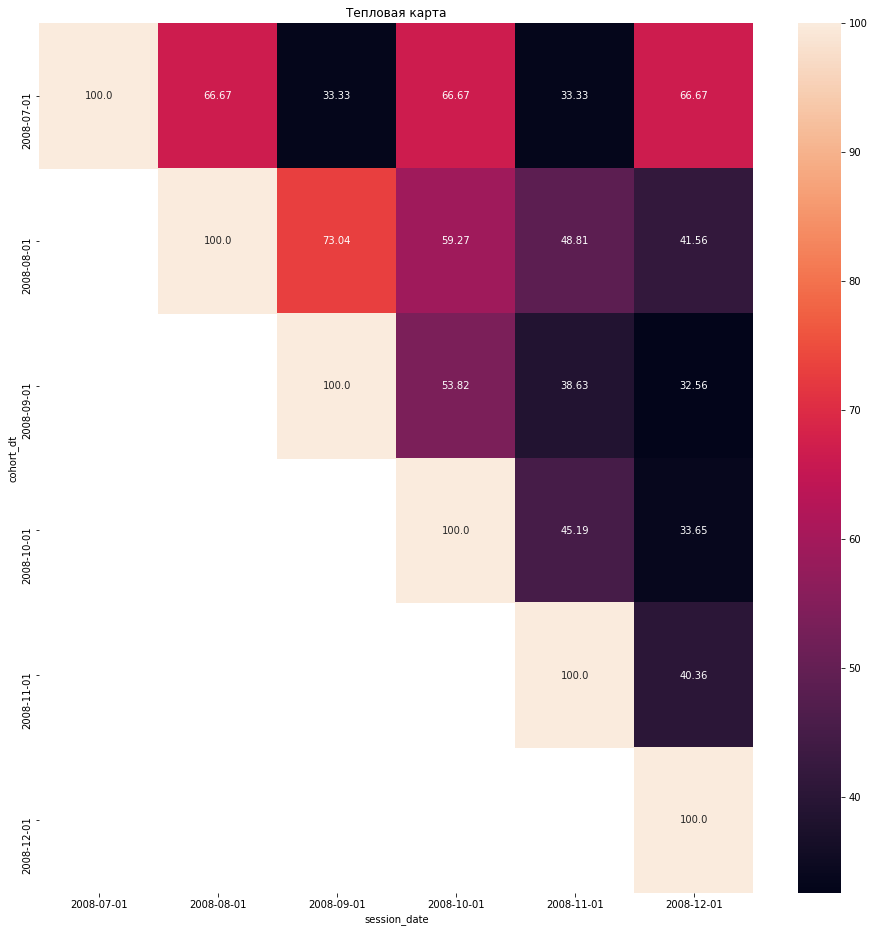

In [15]:
# постройте тепловую карту Retention Rate
retention = df_8.pivot('cohort_dt', 'session_date', 'retention_rate')


plt.figure(figsize=(16, 16)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show()

- Заметно странное поведение пользователей июльской когорты, если в других когортах ежемесячно коэффициент удержания снижался, то в данном случае его значения чередуются каждый месяц. Это похоже на аномалию. Хотя в ней всего 3 участника, воозможно не стоит делать выводов по ней. 
- Так же, когорты, сформированные позже августа имеют тенденцию к снижению значения коэффициента удержания

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [16]:
# напишите запрос
query = '''
WITH tbl AS (
SELECT DISTINCT date_trunc('month',creation_date)::date as dt, COUNT(*) OVER (PARTITION BY date_trunc('month',creation_date)::date order by date_trunc('month',creation_date)::date) as cnt
FROM stackoverflow.posts
WHERE creation_date::date between '2008-09-01' and '2008-12-31'),

tbl2 AS (
SELECT dt, 
       cnt, 
       lag(cnt,1) over () AS previous
from tbl)

SELECT extract(month from dt)::int as creation_month, cnt as posts_count, round((cnt - previous)::numeric/previous * 100 , 2) as percentage
FROM tbl2
'''

# выполните запрос
df_9 = pd.read_sql_query(query, con=engine)
df_9

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

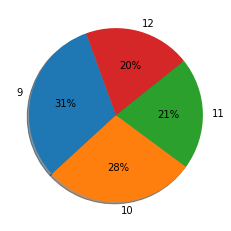

In [17]:
# постройте круговую диаграмму с количеством постов по месяцам

sizes = df_9['posts_count'].to_list()
labels = df_9['creation_month'].to_list()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels,autopct='%1.0f%%',
        shadow=True, startangle=110)
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [18]:
# напишите запрос
query = '''
WITH tbl AS (
SELECT DISTINCT user_id, 
                COUNT(id) OVER (PARTITION BY user_id) as count_posts
FROM stackoverflow.posts
ORDER BY user_id),

tbl2 AS (
SELECT user_id, 
       creation_date as dt,
       extract(week from creation_date) as week_creation
FROM stackoverflow.posts
WHERE user_id in (SELECT user_id
                  FROM tbl
                  ORDER BY count_posts desc
                  LIMIT 1) AND DATE_TRUNC('day',creation_date) BETWEEN '2008-10-01' AND '2008-10-31'
ORDER BY creation_date ) 

SELECT DISTINCT week_creation::int,
                last_value(dt) over (PARTITION BY week_creation ORDER BY dt rows between unbounded preceding and unbounded following)
FROM tbl2
ORDER BY week_creation
'''

# выполните запрос
df_10 = pd.read_sql_query(query, con=engine)
df_10

,week_creation,last_value
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
